In [67]:
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset
import torch.utils.data.dataloader as DataLoader
from torchvision import transforms
from PIL import Image    
import os
import copy
import numpy as np
transform = transforms.Compose([ transforms.ToTensor()])#,transforms.Normalize(mean=(0.5), std=(0.5)) 


class MyDataSet(Dataset):
    def __init__(self, transform,update_dataset=False):

        dataset_path = 'E:\实验数据\数据集\capgMyo\dba-preprocessed-015'
        self.sample_list = list()

        f = open(dataset_path + '/datalist.txt')
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()

        imgs=self.sample_list
        
        self.imgs=[os.path.join(dataset_path,k) for k in imgs]
        self.transforms=transform
        
    def __getitem__(self, index):
        item = self.imgs[index]
        
        pil_img = Image.open(item.split(' _')[0])
        if self.transforms:
                data = self.transforms(pil_img)
                #data = data.unsqueeze(0)
        else:
                pil_img = np.asarray(pil_img)
                data = torch.from_numpy(pil_img)
                #data = data.unsqueeze(0)
        #label = [1  if i+1==int(item.split(' _')[-1]) else 0 for i in range(4)]   
        label =int(item.split(' _')[-1])-1
        label_tensor=torch.from_numpy(np.array(np.float32(label)))

        data, label_tensor = Variable(data).cuda(), Variable(label_tensor).cuda()
        return data, label_tensor
 
    def __len__(self):
        return len(self.sample_list)
    
class testNet(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #    7  
        self.lin3=nn.Linear(512,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        
        out = self.conv1(out)
        
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     
    





cuda_avail = torch.cuda.is_available()
model = testNet().cuda(0)

if cuda_avail:
    model.cuda(0)

convNNs_init = copy.deepcopy(model)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()


def adjust_learning_rate(epoch):
    lr = 0.001
 
    if epoch > 60:
        lr = lr / 1000000
    elif epoch > 50:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10
 
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



def save_models(epoch):
    torch.save(model.state_dict(), "emgConvNNs_{}.model".format(epoch))
print("Chekcpoint saved")
 
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
 
        if cuda_avail:
            images = Variable(images.cuda(0))
            labels = Variable(labels.cuda(0))
 
        # Predict classes using images from the test set
        outputs = model(images)
        prediction = (outputs.data[0]==torch.max(outputs.data)).nonzero()
        test_acc += torch.sum(prediction == labels.data)
 
    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc 
    return test_acc


def train(num_epochs):
    best_acc = 0.0
 
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):

            if cuda_avail:
                images = Variable(images.cuda(0))
                labels = Variable(labels.cuda(0))
 
            optimizer.zero_grad()
            outputs = model(images).cuda(0)
#             print('outputs',outputs.data)
#             print('outputs.size',outputs.size())
#             print('labels.long()',labels.long())
#             import pdb; pdb.set_trace()
            loss = loss_fn(outputs, labels.long())

            loss.backward()
 

            optimizer.step()
 
            train_loss += loss.data * images.size(0)
            #prediction =np.array([ 1 if outputs[0][i]==torch.max(outputs.data) else 0 for i in range(4)])
            prediction = (outputs.data[0]==torch.max(outputs.data)).nonzero()
#             import pdb; pdb.set_trace()
            train_acc += torch.sum(prediction == labels.data)
#             print(train_acc)
 

        adjust_learning_rate(epoch)
 

        train_acc = train_acc 
        train_loss = train_loss / 200
 

        test_acc = test()
 

        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc
 

        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))


Chekcpoint saved


In [ ]:
import random
if __name__ == '__main__':
    dataset = MyDataSet(transform)

#     trainset = torch.utils.data.Subset(dataset,np.arange(100,200))
#     testset = torch.utils.data.Subset(dataset,np.arange(500,600))

    ids = np.arange(start = 0,stop = 20000)
    np.random.shuffle(ids)
    train_ids,test_ids = np.array_split(ids,2)
    trainset = torch.utils.data.Subset(dataset,train_ids)
    testset = torch.utils.data.Subset(dataset,test_ids)
    train_loader  = DataLoader.DataLoader(trainset,batch_size= 1, shuffle = False, num_workers= 0)
    test_loader  = DataLoader.DataLoader(testset,batch_size= 1, shuffle = False, num_workers= 0)

    train(5)
    convNNs_final = copy.deepcopy(model)

# Model loss landscapes visualization

Epoch 0, Train Accuracy: 100.0 , TrainLoss: 2.791546583175659 , Test Accuracy: 122.0
Epoch 1, Train Accuracy: 141.0 , TrainLoss: 2.706199884414673 , Test Accuracy: 153.0
Epoch 2, Train Accuracy: 174.0 , TrainLoss: 2.508167266845703 , Test Accuracy: 172.0
Epoch 3, Train Accuracy: 191.0 , TrainLoss: 2.2938003540039062 , Test Accuracy: 178.0
Epoch 4, Train Accuracy: 201.0 , TrainLoss: 2.123922109603882 , Test Accuracy: 187.0
Epoch 5, Train Accuracy: 216.0 , TrainLoss: 1.9873905181884766 , Test Accuracy: 187.0
Epoch 6, Train Accuracy: 234.0 , TrainLoss: 1.895052194595337 , Test Accuracy: 188.0
Epoch 7, Train Accuracy: 255.0 , TrainLoss: 1.6813621520996094 , Test Accuracy: 199.0
Epoch 8, Train Accuracy: 265.0 , TrainLoss: 1.5705418586730957 , Test Accuracy: 191.0
Epoch 9, Train Accuracy: 273.0 , TrainLoss: 1.3860315084457397 , Test Accuracy: 217.0
Epoch 10, Train Accuracy: 294.0 , TrainLoss: 1.2692123651504517 , Test Accuracy: 228.0
Epoch 11, Train Accuracy: 301.0 , TrainLoss: 1.21369135379

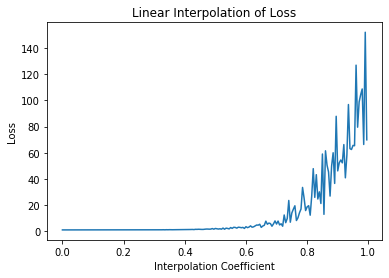

In [68]:
import loss_landscapes
import loss_landscapes.metrics
import matplotlib.pyplot as plt
%matplotlib inline

ids = np.arange(start = 0,stop = 20000)
np.random.shuffle(ids)
train_ids,test_ids = np.array_split(ids,2)
trainset = torch.utils.data.Subset(dataset,np.random.choice(train_ids,400))
testset = torch.utils.data.Subset(dataset,np.random.choice(test_ids,400))
train_loader  = DataLoader.DataLoader(trainset,batch_size= 1, shuffle = False, num_workers= 0)
test_loader  = DataLoader.DataLoader(testset,batch_size= 1, shuffle = False, num_workers= 0)

train(30)
convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 453.0 , TrainLoss: 8.883753776550293 , Test Accuracy: 489.0
Epoch 1, Train Accuracy: 442.0 , TrainLoss: 4.314997673034668 , Test Accuracy: 455.0
Epoch 2, Train Accuracy: 504.0 , TrainLoss: 3.561715602874756 , Test Accuracy: 495.0
Epoch 3, Train Accuracy: 525.0 , TrainLoss: 3.210500478744507 , Test Accuracy: 491.0
Epoch 4, Train Accuracy: 538.0 , TrainLoss: 3.128420114517212 , Test Accuracy: 463.0
Epoch 5, Train Accuracy: 543.0 , TrainLoss: 2.9840409755706787 , Test Accuracy: 483.0
Epoch 6, Train Accuracy: 556.0 , TrainLoss: 2.916759490966797 , Test Accuracy: 489.0
Epoch 7, Train Accuracy: 575.0 , TrainLoss: 2.6590182781219482 , Test Accuracy: 495.0
Epoch 8, Train Accuracy: 596.0 , TrainLoss: 2.6526832580566406 , Test Accuracy: 492.0
Epoch 9, Train Accuracy: 609.0 , TrainLoss: 2.5402534008026123 , Test Accuracy: 483.0
Epoch 10, Train Accuracy: 627.0 , TrainLoss: 2.279620409011841 , Test Accuracy: 490.0
Epoch 11, Train Accuracy: 626.0 , TrainLoss: 2.2639534473419

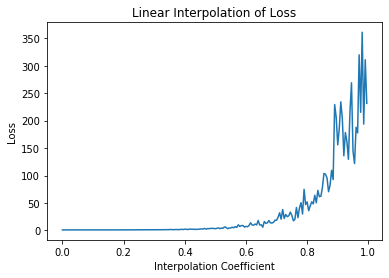

In [69]:
import loss_landscapes
import loss_landscapes.metrics
import matplotlib.pyplot as plt
%matplotlib inline

ids = np.arange(start = 0,stop = 20000)
np.random.shuffle(ids)
train_ids,test_ids = np.array_split(ids,2)
trainset = torch.utils.data.Subset(dataset,np.random.choice(train_ids,800))
testset = torch.utils.data.Subset(dataset,np.random.choice(test_ids,800))
train_loader  = DataLoader.DataLoader(trainset,batch_size= 1, shuffle = False, num_workers= 0)
test_loader  = DataLoader.DataLoader(testset,batch_size= 1, shuffle = False, num_workers= 0)

train(30)
convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 2431.0 , TrainLoss: 32.87613296508789 , Test Accuracy: 2275.0
Epoch 1, Train Accuracy: 2419.0 , TrainLoss: 18.279155731201172 , Test Accuracy: 2393.0
Epoch 2, Train Accuracy: 2531.0 , TrainLoss: 16.955333709716797 , Test Accuracy: 2530.0
Epoch 3, Train Accuracy: 2635.0 , TrainLoss: 16.05128288269043 , Test Accuracy: 2564.0
Epoch 4, Train Accuracy: 2727.0 , TrainLoss: 15.224148750305176 , Test Accuracy: 2563.0
Epoch 5, Train Accuracy: 2809.0 , TrainLoss: 14.283353805541992 , Test Accuracy: 2545.0
Epoch 6, Train Accuracy: 2835.0 , TrainLoss: 13.837389945983887 , Test Accuracy: 2586.0
Epoch 7, Train Accuracy: 2896.0 , TrainLoss: 13.413867950439453 , Test Accuracy: 2606.0
Epoch 8, Train Accuracy: 2953.0 , TrainLoss: 12.67082691192627 , Test Accuracy: 2647.0
Epoch 9, Train Accuracy: 2996.0 , TrainLoss: 12.325844764709473 , Test Accuracy: 2590.0
Epoch 10, Train Accuracy: 3024.0 , TrainLoss: 12.112195014953613 , Test Accuracy: 2603.0
Epoch 11, Train Accuracy: 3025.0 ,

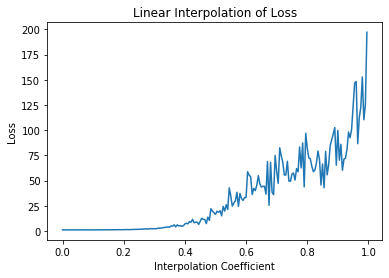

In [70]:
import loss_landscapes
import loss_landscapes.metrics
import matplotlib.pyplot as plt
%matplotlib inline

ids = np.arange(start = 0,stop = 20000)
np.random.shuffle(ids)
train_ids,test_ids = np.array_split(ids,2)
trainset = torch.utils.data.Subset(dataset,np.random.choice(train_ids,4000))
testset = torch.utils.data.Subset(dataset,np.random.choice(test_ids,4000))
train_loader  = DataLoader.DataLoader(trainset,batch_size= 1, shuffle = False, num_workers= 0)
test_loader  = DataLoader.DataLoader(testset,batch_size= 1, shuffle = False, num_workers= 0)

train(30)
convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 146.0 , TrainLoss: 2.393880605697632 , Test Accuracy: 138.0
Epoch 1, Train Accuracy: 129.0 , TrainLoss: 0.9994708299636841 , Test Accuracy: 140.0
Epoch 2, Train Accuracy: 151.0 , TrainLoss: 0.5945448875427246 , Test Accuracy: 141.0
Epoch 3, Train Accuracy: 175.0 , TrainLoss: 0.37564781308174133 , Test Accuracy: 147.0
Epoch 4, Train Accuracy: 183.0 , TrainLoss: 0.21070550382137299 , Test Accuracy: 138.0
Epoch 5, Train Accuracy: 196.0 , TrainLoss: 0.0603109709918499 , Test Accuracy: 140.0
Epoch 6, Train Accuracy: 194.0 , TrainLoss: 0.06192175671458244 , Test Accuracy: 137.0
Epoch 7, Train Accuracy: 182.0 , TrainLoss: 0.4559935927391052 , Test Accuracy: 141.0
Epoch 8, Train Accuracy: 186.0 , TrainLoss: 0.2560013234615326 , Test Accuracy: 143.0
Epoch 9, Train Accuracy: 190.0 , TrainLoss: 0.15969882905483246 , Test Accuracy: 135.0
Epoch 10, Train Accuracy: 187.0 , TrainLoss: 0.15197280049324036 , Test Accuracy: 133.0
Epoch 11, Train Accuracy: 178.0 , TrainLoss: 0.54

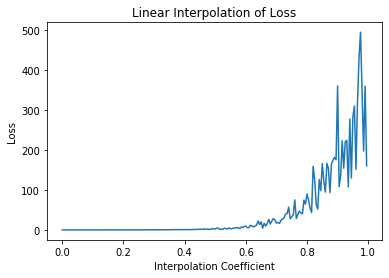

In [71]:
import loss_landscapes
import loss_landscapes.metrics
import matplotlib.pyplot as plt
%matplotlib inline

dataset = MyDataSet(transform)
ids = np.arange(start = 0,stop = 20000)
np.random.shuffle(ids)
train_ids,test_ids = np.array_split(ids,2)
trainset = torch.utils.data.Subset(dataset,np.random.choice(train_ids,200))
testset = torch.utils.data.Subset(dataset,np.random.choice(test_ids,200))
train_loader  = DataLoader.DataLoader(trainset,batch_size= 1, shuffle = False, num_workers= 0)
test_loader  = DataLoader.DataLoader(testset,batch_size= 1, shuffle = False, num_workers= 0)

train(30)
convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

In [ ]:
from torchsummary import summary
def get_weights(net):            return [p.data for p in net.parameters()]
def get_random_weights(weights): return [torch.randn(w.size()) for w in weights]
def normalize_direction(direction, weights,norm='filter'):
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights): 
            # the direction channel gets norm via the channel
            d.mul_(w.norm()/(d.norm() + 1e-10))

    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())

    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same scale as the corresponding weight.
        direction.mul_(weights.cpu())

    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction has the unit norm.
        for d in direction: 
            d.div_(d.norm() + 1e-10)

    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has the unit norm.
        direction.div_(direction.norm())
weight      = get_weights(model)
temp_layer  = 0
for x in weight: 
    temp_layer = temp_layer + 1
    print(str(temp_layer) + " layer " + str(x.shape))

In [ ]:
converged_weights = get_weights(convNNs_final)
import chart_studio.plotly as py
import plotly.graph_objs as go
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(1,20,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
    plt.show()
def create_viz(loss_list,acc_list,title="none"):
    
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

In [ ]:
# create the coordinates
# import tensorflow as tf
numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
inds = np.array(range(numebr_of_points**2))
s1   = xcoord_mesh.ravel()[inds]
s2   = ycoord_mesh.ravel()[inds]
coordinate = np.c_[s1,s2]
print('From ',small_range,' to ',large_range,' with ',numebr_of_points,' total number of coordinate: ', numebr_of_points**2)
copy_of_the_weights = [ w.clone() for w in converged_weights]
# sess = tf.InteractiveSession()
random_direction1 = get_random_weights(copy_of_the_weights)
random_direction2 = [w.clone() for w in random_direction1]
for d,w in zip(random_direction1,copy_of_the_weights):
    normalize_direction(d,w,'filter')
temp = []
for d,w in zip(random_direction2,copy_of_the_weights):
    d_re   = d.view((d.shape[0],-1))
    d_norm = d_re.norm(dim=(1),keepdim=True)[:,:,None,None]
    
    w_re   = w.view((w.shape[0],-1))
    w_norm = w_re.norm(dim=(1),keepdim=True)[:,:,None,None]
    temp.append(d.cuda() * (w_norm.cuda()/(d_norm.cuda()+1e-10)))
    d.data      =  d.cuda() * (w_norm.cuda()/(d_norm.cuda()+1e-10))   

for x, xx in zip(random_direction1,random_direction2):
    print(np.allclose(x.cpu().numpy(),xx.cpu().numpy()))
    
for x, xx in zip(random_direction1,temp):
    print(np.allclose(x.cpu().numpy(),xx.cpu().numpy()))
viz_histogram_weights(copy_of_the_weights,random_direction1,random_direction2)    

In [ ]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(random_direction1, random_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

In [ ]:
loss_data_fin = loss_landscapes.random_plane(convNNs_final, metric, 20, steps, normalization='filter', deepcopy_model=True)
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

In [ ]:
metric.target

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(steps)] for i in range(steps)])
Y = np.array([[i for _ in range(steps)] for i in range(steps)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()


# depth

In [61]:
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset
import torch.utils.data.dataloader as DataLoader
from torchvision import transforms
from PIL import Image    
import os
import copy
import numpy as np
transform = transforms.Compose([ transforms.ToTensor()])#,transforms.Normalize(mean=(0.5), std=(0.5)) 


class MyDataSet(Dataset):
    def __init__(self, transform,update_dataset=False):

        dataset_path = 'E:\实验数据\数据集\capgMyo\dba-preprocessed-015'
        self.sample_list = list()

        f = open(dataset_path + '/datalist.txt')
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()

        imgs=self.sample_list
        
        self.imgs=[os.path.join(dataset_path,k) for k in imgs]
        self.transforms=transform
        
    def __getitem__(self, index):
        item = self.imgs[index]
        
        pil_img = Image.open(item.split(' _')[0])
        if self.transforms:
                data = self.transforms(pil_img)
                #data = data.unsqueeze(0)
        else:
                pil_img = np.asarray(pil_img)
                data = torch.from_numpy(pil_img)
                #data = data.unsqueeze(0)
        #label = [1  if i+1==int(item.split(' _')[-1]) else 0 for i in range(4)]   
        label =int(item.split(' _')[-1])-1
        label_tensor=torch.from_numpy(np.array(np.float32(label)))

        data, label_tensor = Variable(data).cuda(), Variable(label_tensor).cuda()
        return data, label_tensor
 
    def __len__(self):
        return len(self.sample_list)
    
class testNet_depth8(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth8, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #    7  
        self.lin3=nn.Linear(512,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     
class testNet_depth9(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth9, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #+1
        self.lin9=nn.Linear(512,512)
        self.relu9 = nn.ReLU()
        self.dp9 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #    7  
        self.lin3=nn.Linear(512,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #+1
        out = self.lin9(out)
        out = self.relu9(out)
        out = self.dp9(out)       
        
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     
    
    
    
    
class testNet_depth7(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth7, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #    6   --
        #self.lin2=nn.Linear(512,512)
        #self.relu6 = nn.ReLU()
        #self.dp6 =nn.Dropout()
        #    7  
        self.lin3=nn.Linear(512,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #6        
        #out = self.lin2(out)
        #out = self.relu6(out)
        #out = self.dp6(out)
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     

    
    
class testNet_depth6(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth6, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,256)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #    6   --
        #self.lin2=nn.Linear(512,512)
        #self.relu6 = nn.ReLU()
        #self.dp6 =nn.Dropout()
        #    7  
        #self.lin3=nn.Linear(512,128)
        #self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(256,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #6        
        #out = self.lin2(out)
        #out = self.relu6(out)
        #out = self.dp6(out)
        #7        
        #out = self.lin3(out)
        #out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out   
    
    
    
class testNet_depth5(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth5, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        #self.lin1=nn.Linear(64*2*6,256)
        #self.relu5 = nn.ReLU()
        #self.dp5 = nn.Dropout()
        #    6   --
        #self.lin2=nn.Linear(512,512)
        #self.relu6 = nn.ReLU()
        #self.dp6 =nn.Dropout()
        #    7  
        #self.lin3=nn.Linear(512,128)
        #self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(64*2*6,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        #out = self.lin1(out)
        #out = self.relu5(out)
        #out = self.dp5(out)
        #6        
        #out = self.lin2(out)
        #out = self.relu6(out)
        #out = self.dp6(out)
        #7        
        #out = self.lin3(out)
        #out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out       
    
    
class testNet_depth10(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth10, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #+1
        self.lin9=nn.Linear(512,512)
        self.relu9 = nn.ReLU()
        self.dp9 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #+2
        self.lin10=nn.Linear(512,256)
        self.relu10 = nn.ReLU()
        #    7  
        self.lin3=nn.Linear(256,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #+1
        out = self.lin9(out)
        out = self.relu9(out)
        out = self.dp9(out)       
        
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #+2
        out = self.lin10(out)
        out = self.relu10(out)        
        
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     
    
    
class testNet_depth15(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth15, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #+1
        self.lin9=nn.Linear(512,512)
        self.relu9 = nn.ReLU()
        self.dp9 = nn.Dropout()
        #+4
        self.lin12=nn.Linear(512,512)
        self.relu12 = nn.ReLU()
        self.dp12 = nn.Dropout()
        #+5
        self.lin13=nn.Linear(512,512)
        self.relu13 = nn.ReLU()
        self.dp13 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #+2
        self.lin10=nn.Linear(512,256)
        self.relu10 = nn.ReLU()
        #+3
        self.lin11=nn.Linear(256,256)
        self.relu11 = nn.ReLU()
        #+6
        self.lin14=nn.Linear(256,256)
        self.relu14= nn.ReLU()        
        #+7
        self.lin15=nn.Linear(256,256)
        self.relu15 = nn.ReLU()        
        #    7  
        self.lin3=nn.Linear(256,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #+1
        out = self.lin9(out)
        out = self.relu9(out)
        out = self.dp9(out)       
        #+4
        out = self.lin12(out)
        out = self.relu12(out)
        out = self.dp12(out)       
        #+5
        out = self.lin13(out)
        out = self.relu13(out)
        out = self.dp13(out)               
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #+2
        out = self.lin10(out)
        out = self.relu10(out)        
        #+3
        out = self.lin11(out)
        out = self.relu11(out)     
        #+6
        out = self.lin14(out)
        out = self.relu14(out)            
        #+7
        out = self.lin15(out)
        out = self.relu15(out)            
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     



class testNet_depth11(nn.Module):
    def __init__(self, num_classes=4):
        super(testNet_depth11, self).__init__()
        #    1  
        self.BN1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=1,padding=0)
        self.relu1 = nn.ReLU()
        #    2  
        self.BN2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        #    3  
        self.lc1=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu3 = nn.ReLU()
        #    4  
        self.lc2=nn.Conv2d(64,64,kernel_size=1,stride=1)##LocallyConnected2d
        self.relu4 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Max-pool
        #    5  
        self.lin1=nn.Linear(64*2*6,512)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout()
        #+1
        self.lin9=nn.Linear(512,512)
        self.relu9 = nn.ReLU()
        self.dp9 = nn.Dropout()
        #    6  
        self.lin2=nn.Linear(512,512)
        self.relu6 = nn.ReLU()
        self.dp6 =nn.Dropout()
        #+2
        self.lin10=nn.Linear(512,256)
        self.relu10 = nn.ReLU()
        #+3
        self.lin11=nn.Linear(256,256)
        self.relu11 = nn.ReLU()
        #    7  
        self.lin3=nn.Linear(256,128)
        self.relu7 = nn.ReLU()
        #    8  
        self.lin4=nn.Linear(128,4)
        self.sm1 = nn.Softmax()
        
        # flatten operation is needed
    def forward(self,x):
        #1
        out = self.BN1(x)
        out = self.conv1(out)
        out = self.relu1(out)
        
        #2       
        out = self.BN2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        #3       
        out = self.lc1(out)
        out = self.relu3(out)
        #4        
        out = self.lc2(out)
        out = self.relu4(out)
        
        out = self.pool1(out)
        out=out.flatten()
        
        #5       
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.dp5(out)
        #+1
        out = self.lin9(out)
        out = self.relu9(out)
        out = self.dp9(out)       
        
        #6        
        out = self.lin2(out)
        out = self.relu6(out)
        out = self.dp6(out)
        #+2
        out = self.lin10(out)
        out = self.relu10(out)        
        #+3
        out = self.lin11(out)
        out = self.relu11(out)             
        #7        
        out = self.lin3(out)
        out = self.relu7(out)
        #8        
        out = self.lin4(out)
        #out = self.sm1(out)
        out = out.unsqueeze(0)
        return out     



def adjust_learning_rate(epoch):
    lr = 0.001
 
    if epoch > 60:
        lr = lr / 1000000
    elif epoch > 50:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10
 
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def save_modle_depths(epoch):
    torch.save(model.state_dict(), "emgConvNNs_Depth8_{}.model".format(epoch))
print("Chekcpoint saved")
 
def test_depths(Model):
    model=Model
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
 
        if cuda_avail:
            images = Variable(images.cuda(0))
            labels = Variable(labels.cuda(0))
 
        # Predict classes using images from the test set
        outputs = model(images)
        prediction = (outputs.data[0]==torch.max(outputs.data)).nonzero()
        test_acc += torch.sum(prediction == labels.data)
 
    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc/4000 
    return test_acc


def train_depths(num_epochs,Net):
    
    model =Net.cuda(0)

    convNNs_init = copy.deepcopy(model)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0
 
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):

            if cuda_avail:
                images = Variable(images.cuda(0))
                labels = Variable(labels.cuda(0))
 
            optimizer.zero_grad()
            outputs = model(images).cuda(0)
#             print('outputs',outputs.data)
#             print('outputs.size',outputs.size())
#             print('labels.long()',labels.long())
#             import pdb; pdb.set_trace()
            loss = loss_fn(outputs, labels.long())
            loss.backward()
            optimizer.step()
 
            train_loss += loss.data * images.size(0)
            #prediction =np.array([ 1 if outputs[0][i]==torch.max(outputs.data) else 0 for i in range(4)])
            prediction = (outputs.data[0]==torch.max(outputs.data)).nonzero()
#             import pdb; pdb.set_trace()
            train_acc += torch.sum(prediction == labels.data)
#             print(train_acc)
        adjust_learning_rate(epoch)
        train_acc = train_acc/ 2000
        train_loss = train_loss / 2000
        test_acc = test_depths(model)

        if test_acc > best_acc:
            save_modle_depths(epoch)
            convNNs_final = copy.deepcopy(model)
            best_acc = test_acc/ 2000

        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))

Chekcpoint saved


Epoch 0, Train Accuracy: 0.19675001502037048 , TrainLoss: 0.6366304755210876 , Test Accuracy: 0.2550000250339508
Epoch 1, Train Accuracy: 0.257750004529953 , TrainLoss: 0.5305935144424438 , Test Accuracy: 0.2782500088214874
Epoch 2, Train Accuracy: 0.29200002551078796 , TrainLoss: 0.4612065255641937 , Test Accuracy: 0.265500009059906
Epoch 3, Train Accuracy: 0.3005000054836273 , TrainLoss: 0.43129733204841614 , Test Accuracy: 0.2985000014305115
Epoch 4, Train Accuracy: 0.31550002098083496 , TrainLoss: 0.4190482199192047 , Test Accuracy: 0.3100000023841858
Epoch 5, Train Accuracy: 0.32750001549720764 , TrainLoss: 0.38084840774536133 , Test Accuracy: 0.31825000047683716
Epoch 6, Train Accuracy: 0.335750013589859 , TrainLoss: 0.37925997376441956 , Test Accuracy: 0.3255000114440918
Epoch 7, Train Accuracy: 0.3517500162124634 , TrainLoss: 0.34170231223106384 , Test Accuracy: 0.2892500162124634
Epoch 8, Train Accuracy: 0.35200002789497375 , TrainLoss: 0.34261462092399597 , Test Accuracy: 0.3

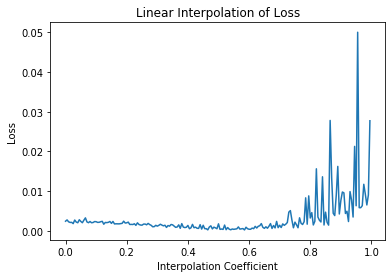

In [59]:
#原始网络结构
import loss_landscapes
import loss_landscapes.metrics
import matplotlib.pyplot as plt
%matplotlib inline

ids = np.arange(start = 0,stop = 20000)
np.random.shuffle(ids)
train_ids,test_ids = np.array_split(ids,2)
trainset2 = torch.utils.data.Subset(dataset,np.random.choice(train_ids,2000))
testset2 = torch.utils.data.Subset(dataset,np.random.choice(test_ids,2000))
train_loader2  = DataLoader.DataLoader(trainset2,batch_size= 1, shuffle = False, num_workers= 0)
test_loader2  = DataLoader.DataLoader(testset2,batch_size= 1, shuffle = False, num_workers= 0)

Net = testNet_depth8()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.15675000846385956 , TrainLoss: 0.6743015646934509 , Test Accuracy: 0.20400001108646393
Epoch 1, Train Accuracy: 0.21400001645088196 , TrainLoss: 0.5979185700416565 , Test Accuracy: 0.21575000882148743
Epoch 2, Train Accuracy: 0.22150000929832458 , TrainLoss: 0.5611509680747986 , Test Accuracy: 0.21800000965595245
Epoch 3, Train Accuracy: 0.23250001668930054 , TrainLoss: 0.5397824645042419 , Test Accuracy: 0.22150000929832458
Epoch 4, Train Accuracy: 0.23275001347064972 , TrainLoss: 0.5294017195701599 , Test Accuracy: 0.2200000137090683
Epoch 5, Train Accuracy: 0.2370000183582306 , TrainLoss: 0.5163499712944031 , Test Accuracy: 0.2357500046491623
Epoch 6, Train Accuracy: 0.2472500056028366 , TrainLoss: 0.5162638425827026 , Test Accuracy: 0.24400001764297485
Epoch 7, Train Accuracy: 0.2562500238418579 , TrainLoss: 0.49414995312690735 , Test Accuracy: 0.23650000989437103
Epoch 8, Train Accuracy: 0.2757500112056732 , TrainLoss: 0.47655001282691956 , Test Accuracy

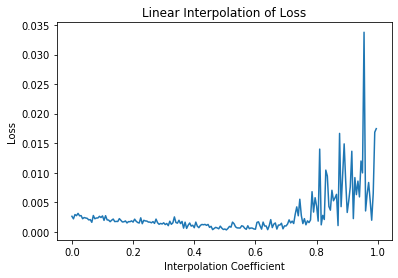

In [60]:
#增加一层深度
Net = testNet_depth9()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.4425000250339508 , TrainLoss: 1.1948126554489136 , Test Accuracy: 0.2827500104904175
Epoch 1, Train Accuracy: 0.5905000567436218 , TrainLoss: 0.9112349152565002 , Test Accuracy: 0.28950002789497375
Epoch 2, Train Accuracy: 0.6445000171661377 , TrainLoss: 0.7936021685600281 , Test Accuracy: 0.31150001287460327
Epoch 3, Train Accuracy: 0.6760000586509705 , TrainLoss: 0.7254397869110107 , Test Accuracy: 0.3135000169277191
Epoch 4, Train Accuracy: 0.7000000476837158 , TrainLoss: 0.6783339977264404 , Test Accuracy: 0.3097500205039978
Epoch 5, Train Accuracy: 0.7280000448226929 , TrainLoss: 0.6408500075340271 , Test Accuracy: 0.3205000162124634
Epoch 6, Train Accuracy: 0.7415000200271606 , TrainLoss: 0.5983255505561829 , Test Accuracy: 0.32100000977516174
Epoch 7, Train Accuracy: 0.7675000429153442 , TrainLoss: 0.528416633605957 , Test Accuracy: 0.33125001192092896
Epoch 8, Train Accuracy: 0.7800000309944153 , TrainLoss: 0.5296005606651306 , Test Accuracy: 0.324750

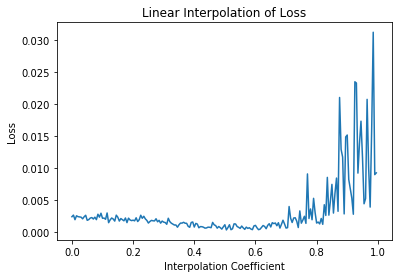

In [62]:
#减少一层深度
Net = testNet_depth7()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.24450001120567322 , TrainLoss: 1.390075922012329 , Test Accuracy: 0.1275000125169754
Epoch 1, Train Accuracy: 0.24000000953674316 , TrainLoss: 1.387338399887085 , Test Accuracy: 0.1275000125169754
Epoch 2, Train Accuracy: 0.2460000067949295 , TrainLoss: 1.3875398635864258 , Test Accuracy: 0.1275000125169754
Epoch 3, Train Accuracy: 0.24250000715255737 , TrainLoss: 1.387489914894104 , Test Accuracy: 0.1275000125169754
Epoch 4, Train Accuracy: 0.24150000512599945 , TrainLoss: 1.389147162437439 , Test Accuracy: 0.1275000125169754
Epoch 5, Train Accuracy: 0.2580000162124634 , TrainLoss: 1.3881556987762451 , Test Accuracy: 0.1275000125169754
Epoch 6, Train Accuracy: 0.2370000183582306 , TrainLoss: 1.3889034986495972 , Test Accuracy: 0.1275000125169754
Epoch 7, Train Accuracy: 0.2565000057220459 , TrainLoss: 1.3869529962539673 , Test Accuracy: 0.12375000864267349
Epoch 8, Train Accuracy: 0.24900001287460327 , TrainLoss: 1.3895082473754883 , Test Accuracy: 0.1275000

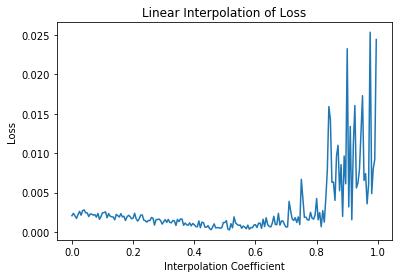

In [63]:
#增加两层深度
Net = testNet_depth10()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.2510000169277191 , TrainLoss: 1.3895494937896729 , Test Accuracy: 0.1275000125169754
Epoch 1, Train Accuracy: 0.24450001120567322 , TrainLoss: 1.388168215751648 , Test Accuracy: 0.1275000125169754
Epoch 2, Train Accuracy: 0.25050002336502075 , TrainLoss: 1.3878560066223145 , Test Accuracy: 0.1275000125169754
Epoch 3, Train Accuracy: 0.22950001060962677 , TrainLoss: 1.388185739517212 , Test Accuracy: 0.12375000864267349
Epoch 4, Train Accuracy: 0.24800001084804535 , TrainLoss: 1.3882981538772583 , Test Accuracy: 0.1275000125169754
Epoch 5, Train Accuracy: 0.2395000159740448 , TrainLoss: 1.3876701593399048 , Test Accuracy: 0.1275000125169754
Epoch 6, Train Accuracy: 0.2515000104904175 , TrainLoss: 1.3879828453063965 , Test Accuracy: 0.1275000125169754
Epoch 7, Train Accuracy: 0.23650000989437103 , TrainLoss: 1.3874726295471191 , Test Accuracy: 0.1275000125169754
Epoch 8, Train Accuracy: 0.23850001394748688 , TrainLoss: 1.3883411884307861 , Test Accuracy: 0.1275

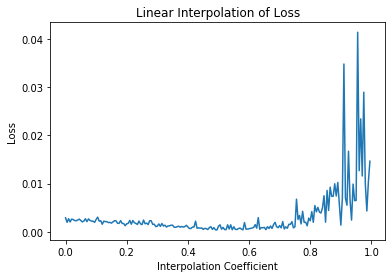

In [64]:
#增加三层深度
Net = testNet_depth11()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.24900001287460327 , TrainLoss: 1.3881733417510986 , Test Accuracy: 0.1275000125169754
Epoch 1, Train Accuracy: 0.2395000159740448 , TrainLoss: 1.3880047798156738 , Test Accuracy: 0.1275000125169754
Epoch 2, Train Accuracy: 0.23850001394748688 , TrainLoss: 1.3874075412750244 , Test Accuracy: 0.1275000125169754
Epoch 3, Train Accuracy: 0.24050001800060272 , TrainLoss: 1.3876278400421143 , Test Accuracy: 0.1275000125169754
Epoch 4, Train Accuracy: 0.242000013589859 , TrainLoss: 1.387114405632019 , Test Accuracy: 0.1275000125169754
Epoch 5, Train Accuracy: 0.2485000044107437 , TrainLoss: 1.3870686292648315 , Test Accuracy: 0.1275000125169754
Epoch 6, Train Accuracy: 0.24800001084804535 , TrainLoss: 1.3863525390625 , Test Accuracy: 0.1275000125169754
Epoch 7, Train Accuracy: 0.23900000751018524 , TrainLoss: 1.3891648054122925 , Test Accuracy: 0.1275000125169754
Epoch 8, Train Accuracy: 0.24700000882148743 , TrainLoss: 1.3884973526000977 , Test Accuracy: 0.12750001

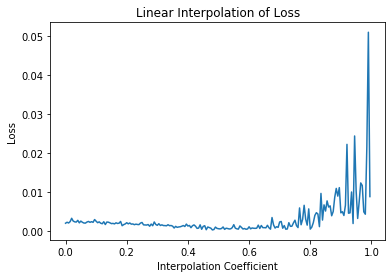

In [65]:
#增加七层深度
Net = testNet_depth15()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)

plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

Epoch 0, Train Accuracy: 0.48850002884864807 , TrainLoss: 1.1301926374435425 , Test Accuracy: 0.2697499990463257
Epoch 1, Train Accuracy: 0.6155000329017639 , TrainLoss: 0.8640289902687073 , Test Accuracy: 0.3007500171661377
Epoch 2, Train Accuracy: 0.6465000510215759 , TrainLoss: 0.7777776122093201 , Test Accuracy: 0.3152500092983246
Epoch 3, Train Accuracy: 0.7075000405311584 , TrainLoss: 0.6829107999801636 , Test Accuracy: 0.3150000274181366
Epoch 4, Train Accuracy: 0.7255000472068787 , TrainLoss: 0.6487678289413452 , Test Accuracy: 0.31200000643730164
Epoch 5, Train Accuracy: 0.7425000071525574 , TrainLoss: 0.5879161953926086 , Test Accuracy: 0.3217500150203705
Epoch 6, Train Accuracy: 0.7835000157356262 , TrainLoss: 0.5168226361274719 , Test Accuracy: 0.3227500021457672
Epoch 7, Train Accuracy: 0.7835000157356262 , TrainLoss: 0.5083273649215698 , Test Accuracy: 0.31825000047683716
Epoch 8, Train Accuracy: 0.8010000586509705 , TrainLoss: 0.4678705036640167 , Test Accuracy: 0.319000

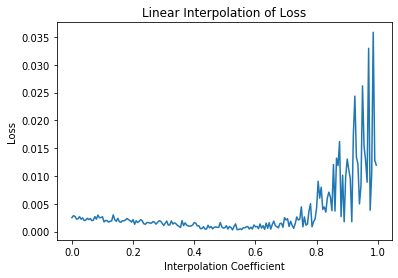

In [66]:
#减少二层深度
Net = testNet_depth6()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)

plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

In [ ]:

#减少三层深度
Net = testNet_depth5()
train_depths(40,Net)
#convNNs_final = copy.deepcopy(model)

X_1,y_1 = iter(train_loader2).__next__()
# X_1 = X_1.long()
# y_1 = y_1.long()
criterion = torch.nn.MSELoss()
metric = loss_landscapes.metrics.Loss(criterion, X_1, y_1)

# compute loss data
steps=200
loss_data = loss_landscapes.linear_interpolation(convNNs_init, convNNs_final, metric, steps, deepcopy_model=True)

plt.plot([1/steps * i for i in range(steps)], loss_data)

plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()